# Background Methods

In [2]:
import traceback
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from WF_SDK import device
from WF_SDK import scope
from WF_SDK import wavegen

%matplotlib inline

In [3]:
class ADSHardware():
    """Class of functions for interfacing with the ADS.
    """

    def __init__(self):
        self.handle = None

    def startup(self):
        """Connects to the ADS. Defines 'handle', the address to the ADS.
        Must be run at the beginning of every program using the ADS.
        """
        self.handle = device.open()

    def open_scope(self, buffer_size=1000, sample_freq=100e6):
        """Opens connection to the scope.

        Args:
            buffer_size (int, optional): How many data points are temporarily stored
            before being returned. The buffer is a temporary slot for storing a small amount of
            data before it is transferred to its final destination. Defaults to 1000.
            sample_freq (int, optional): How frequently the oscilloscope will sample
            from the input. Defaults to 100e6. You can decrease this if you have too
            many data points/the function is taking awhile to run for the time scale you need.
            (1e6 or even 16e3 can be reasonable selections.)
        """
        scope.open(self.handle, buffer_size=buffer_size, sampling_frequency=sample_freq)

    def trigger_scope(self, channel=1, level=0.1):
        """Sets trigger level for the scope. Kind of a buggy function; not used.

        Args:
            channel (int, optional): Selects which channel of scope to read out. 
            Defaults to 1.
            level (float, optional): Sets trigger level for scope. Defaults to 0.1.
        """
        scope.trigger(self.handle, enable=True, source=scope.trigger_source.analog, channel=channel,
                      edge_rising=True, level=level)

    def read_scope(self, channel=1):
        """Collects data from the scope.

        Args:
            channel (int, optional): Which channel to read from. Defaults to 1.

        Returns:
            buffer (array): An array of output data points. The buffer is a temporary slot 
            for storing a small amount of data before it is transferred to its final destination.
        """
        buffer = scope.record(self.handle, channel=channel)
        return buffer

    def close_scope(self):
        """Closes connection to the scope.
        """
        scope.close(self.handle)

    def use_wavegen(self, channel=1, function=wavegen.function.sine, offset_v=0, freq_hz=1e3, amp_v=1):
        """Runs the wavegen producing function with given parameters.

        Args:
            channel (int, optional): Which channel output is at. Defaults to 1.
            function (function object, optional): What type of function to output. 
            Defaults to wavegen.function.sine.
            offset (int, optional): Voltage offset (V). Defaults to 0.
            freq (int, optional): Frequency (Hz). Defaults to 1e3.
            amp (int, optional): Amplitude (V). Defaults to 1.
        """
        wavegen.generate(self.handle, channel=channel, function=function, offset=offset_v,
                         frequency=freq_hz, amplitude=amp_v)

    def close_wavegen(self):
        """Closes wavegen.
        """
        wavegen.close(self.handle)

    def disconnect(self):
        """Closes ADS connection. Must be run at the end of every program.
        """
        device.close(self.handle)

In [4]:
def oscilloscope_run(ads_object: ADSHardware, duration: float, channel: int, sampling_freq=400000):
    """Collects data from the oscilloscope.

    Args:
        ads_object (ADSHardware object): the ADS being used
        duration (int): time length of trace to collect in seconds
        channel (int): which channel to collect data from
        sampling_freq (int, optional): How frequently the oscilloscope will sample (Hz)
        from the input. Defaults to 1e6. You can decrease this if you have too
        many data points/the function is taking awhile to run for the time scale you need.
        (16e3 can be a reasonable selection.)

    Returns:
        data (dict): has two keys, "x" and "y" which have time (ms) and voltage (V) data
    """
    buffer_size = int(duration * sampling_freq)
    data = {}
    ads_object.open_scope(sample_freq=sampling_freq, buffer_size=buffer_size)

    MS_CONVERSION = 1e3

    buffer = ads_object.read_scope(channel=channel)
    data["y"] = buffer

    #MODIFY THE LINE BELOW THIS ONE IN L10.2(d)
    data["x"] = np.arange(buffer_size) / sampling_freq * MS_CONVERSION
    
    ads_object.close_scope()
    return data

In [5]:
wavegen_functions = {"sine":wavegen.function.sine, "square":wavegen.function.square,
                     "triangle":wavegen.function.triangle, "dc":wavegen.function.dc, "pulse": wavegen.function.pulse}

# Sonar

In [6]:
ads = ADSHardware()
ads.startup()

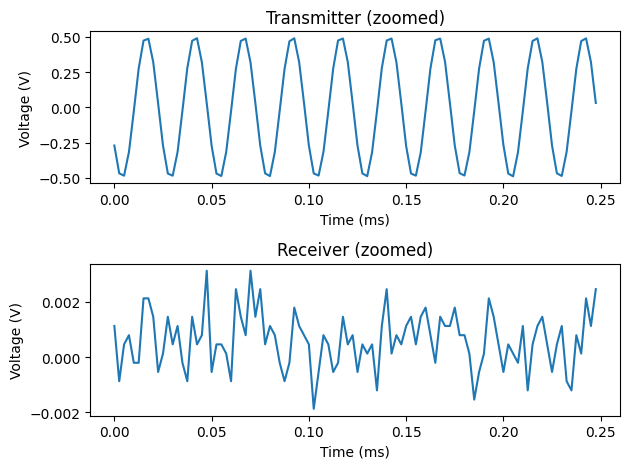

In [6]:
freq  = 40e3
Amp   = 0.5
pulse = 0.02

ads.use_wavegen(channel=1, function=wavegen_functions["sine"], offset_v=0, freq_hz=freq, amp_v=Amp)

sampling_rate = 400000

tx_data = oscilloscope_run(ads, pulse, 1, sampling_freq=sampling_rate)   # transmitter
rx_data = oscilloscope_run(ads, pulse, 2, sampling_freq=sampling_rate)   # receiver

ads.close_wavegen()

t_tx = np.array(tx_data["x"])
v_tx = np.array(tx_data["y"])
t_rx = np.array(rx_data["x"])
v_rx = np.array(rx_data["y"])

# Zoom window (0–0.5 ms)
mask_tx = t_tx < 0.25    # ms
mask_rx = t_rx < 0.25

plt.figure()
plt.subplot(2,1,1)
plt.plot(t_tx[mask_tx], v_tx[mask_tx])
plt.title("Transmitter (zoomed)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")

plt.subplot(2,1,2)
plt.plot(t_rx[mask_rx], v_rx[mask_rx])
plt.title("Receiver (zoomed)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")

plt.tight_layout()
plt.show()

# Sonar Pulse

In [7]:
def oscilloscope_run_two(ads_object: ADSHardware,
                         duration: float,
                         sampling_freq: int = 400_000):
    """
    Collects data from BOTH oscilloscope channels in one go
    (sequential reads with same timing config).

    Returns:
        data (dict): keys "t_ms", "ch1", "ch2"
    """
    buffer_size = int(duration * sampling_freq)

    # Configure scope timing
    ads_object.open_scope(sample_freq=sampling_freq, buffer_size=buffer_size)

    # READ CHANNEL 1
    # Change 'channel=' to whatever your ADSHardware.read_scope expects (e.g. ch=1)
    buf1 = ads_object.read_scope(channel=1)
    # READ CHANNEL 2
    buf2 = ads_object.read_scope(channel=2)

    ads_object.close_scope()

    # Time axis in ms
    t_ms = np.arange(buffer_size) / sampling_freq * 1e3

    # Make sure these are 1-D arrays of length buffer_size
    ch1 = np.array(buf1).flatten()
    ch2 = np.array(buf2).flatten()

    print("ch1 shape:", ch1.shape, "ch2 shape:", ch2.shape)  # debug

    return {"t_ms": t_ms, "ch1": ch1, "ch2": ch2}


Device opened.
Recorded: 20000 samples.
Time-of-flight (Tx→echo) ≈ 2.154 ms
Estimated distance        ≈ 0.369 m
Echo arrival time in record ≈ 2.154 ms after record start


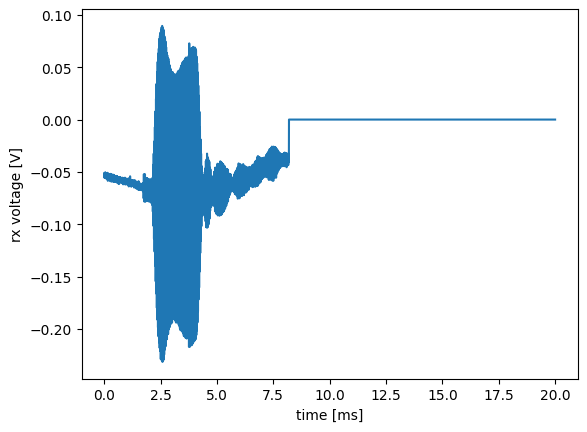

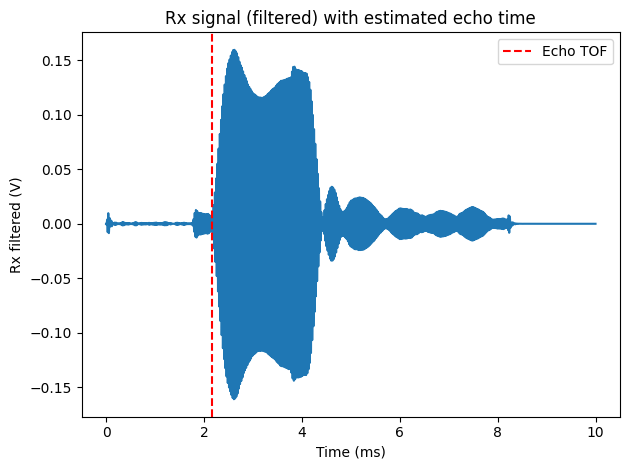

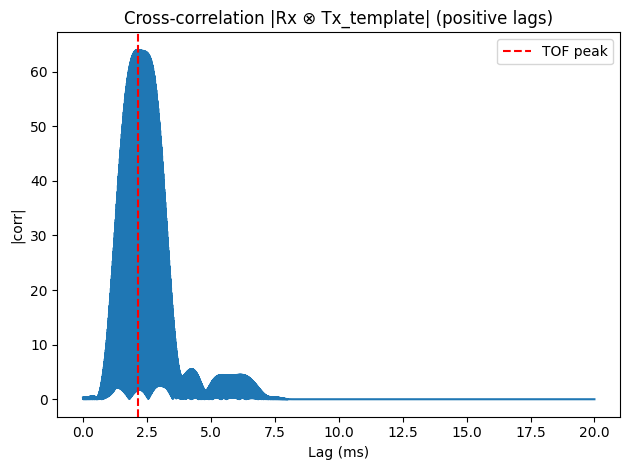

Device closed.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

from WF_SDK import wavegen
from WF_SDK import scope
from WF_SDK import device

# -----------------------------
# Your ADS wrapper
# -----------------------------
class ADSHardware():
    def __init__(self):
        self.handle = None

    def startup(self):
        self.handle = device.open()

    def open_scope(self, buffer_size=1000, sample_freq=1e6):
        scope.open(self.handle, buffer_size=buffer_size, sampling_frequency=sample_freq)

    def read_scope(self, channel=1):
        buffer = scope.record(self.handle, channel=channel)   # ONE return value
        return buffer

    def close_scope(self):
        scope.close(self.handle)

    def disconnect(self):
        device.close(self.handle)


# -----------------------------
# Constants / parameters
# -----------------------------
SOUND_SPEED   = 343.0      # m/s
F_ULTRA       = 40e3       # 40 kHz carrier
BURST_CYCLES  = 80         # cycles per burst
BURST_T       = BURST_CYCLES / F_ULTRA    # ~1 ms burst
WAIT_BEFORE   = 2e-3       # 2 ms wait before burst starts
CAPTURE_T     = 0.02       # 20 ms capture window
FS_SCOPE      = 1_000_000  # 1 MS/s scope sample rate
AWG_VPP       = 4.0        # 4 Vpp at Wavegen output (±2 V)

# -----------------------------
# Start ADS and scope
# -----------------------------
ads = ADSHardware()
ads.startup()
print("Device opened.")

N_SAMPLES = int(FS_SCOPE * CAPTURE_T)
ads.open_scope(buffer_size=N_SAMPLES, sample_freq=FS_SCOPE)

# -----------------------------
# Configure Wavegen burst on CH1
# -----------------------------
# NOTE: we call generate FIRST with a 2 ms wait, so that when we
# call scope.record right after, the scope will be running by
# the time the burst actually happens.
wavegen.generate(
    ads.handle,
    channel=1,
    function=wavegen.function.sine,
    offset=0.0,
    frequency=F_ULTRA,
    amplitude=AWG_VPP / 2,    # amplitude is peak, not p-p
    symmetry=50,
    wait=WAIT_BEFORE,         # wait before starting burst
    run_time=BURST_T,         # duration of output
    repeat=1,                 # one burst
    data=[]
)

# -----------------------------
# Record Rx channel (CH2)
# -----------------------------
rx_buffer = ads.read_scope(channel=2)   # <--- ONE return value

# Build time axis ourselves
t = np.arange(N_SAMPLES) / FS_SCOPE     # seconds
rx_raw = np.asarray(rx_buffer)

print("Recorded:", rx_raw.shape[0], "samples.")

# -----------------------------
# Build known Tx template in software
# -----------------------------
N_pulse = int(BURST_T * FS_SCOPE)
dt = 1.0 / FS_SCOPE
t_pulse = np.arange(N_pulse) * dt

tx_template = np.sin(2 * np.pi * F_ULTRA * t_pulse)

# Window to reduce sidelobes
window = np.hanning(N_pulse)
tx_template *= window

# -----------------------------
# Bandpass filter Rx around 40 kHz
# -----------------------------
low = 30e3
high = 50e3
b, a = sig.butter(4, [low, high], btype="bandpass", fs=FS_SCOPE)
rx_f = sig.lfilter(b, a, rx_raw)

# -----------------------------
# Cross-correlate Rx with Tx template
# -----------------------------
corr = sig.correlate(rx_f, tx_template, mode="full")
lags = sig.correlation_lags(len(rx_f), len(tx_template), mode="full")
lag_sec = lags / FS_SCOPE
corr_abs = np.abs(corr)

# Only positive lags (responses after transmit)
pos_mask = lag_sec >= 0
lags_pos = lags[pos_mask]
lag_sec_pos = lag_sec[pos_mask]
corr_pos = corr_abs[pos_mask]

# Strongest peak at positive lag = TOF
idx_peak = np.argmax(corr_pos)
lag_samples_tof = lags_pos[idx_peak]
dt_tof = lag_samples_tof / FS_SCOPE

distance = 0.5 * SOUND_SPEED * dt_tof

print(f"Time-of-flight (Tx→echo) ≈ {dt_tof*1e3:.3f} ms")
print(f"Estimated distance        ≈ {distance:.3f} m")

# -----------------------------
# "Timestamp" inside record
# -----------------------------
# Record starts at t=0 by construction
t_echo_record = dt_tof
print(f"Echo arrival time in record ≈ {t_echo_record*1e3:.3f} ms after record start")

# -----------------------------
# Plots for sanity
# -----------------------------


plt.plot(t*1e3, rx_buffer)
plt.xlabel("time [ms]")
plt.ylabel("rx voltage [V]")
plt.show()

mask_zoom = (t >= 0) & (t <= 0.01)  # 0–10 ms

plt.figure()
plt.plot(t[mask_zoom]*1e3, rx_f[mask_zoom])
plt.axvline(dt_tof*1e3, color="r", linestyle="--", label="Echo TOF")
plt.xlabel("Time (ms)")
plt.ylabel("Rx filtered (V)")
plt.title("Rx signal (filtered) with estimated echo time")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(lag_sec_pos*1e3, corr_pos)
plt.axvline(dt_tof*1e3, color="r", linestyle="--", label="TOF peak")
plt.xlabel("Lag (ms)")
plt.ylabel("|corr|")
plt.title("Cross-correlation |Rx ⊗ Tx_template| (positive lags)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Cleanup
# -----------------------------
ads.close_scope()
ads.disconnect()
print("Device closed.")

# Multiple Bursts

In [32]:
import time
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# ---- helper: do ONE ping & return TOF, distance, and optionally debug info ----
def measure_once(ads,
                 FS_SCOPE=1_000_000,
                 CAPTURE_T=0.02,
                 F_ULTRA=40e3,
                 BURST_T=40/40e3,
                 AWG_VPP=4.0,
                 WAIT_BEFORE=2e-3,
                 SOUND_SPEED=343.0,
                 d_min=0.2,   # m: ignore echoes closer than this (direct coupling etc.)
                 d_max=2.5):  # m: ignore echoes farther than this
    """
    Fire one burst, record Rx, compute TOF and distance.
    Returns dt_tof (s), distance (m), and some extra info.
    """

    # --- 1. Configure burst on CH1 (one ping) ---
    wavegen.generate(
        ads.handle,
        channel=1,
        function=wavegen.function.sine,
        offset=0.0,
        frequency=F_ULTRA,
        amplitude=AWG_VPP / 2,
        symmetry=50,
        wait=WAIT_BEFORE,
        run_time=BURST_T,
        repeat=1,
        data=[]
    )

    # --- 2. Record CH2 ---
    N_SAMPLES = int(FS_SCOPE * CAPTURE_T)
    rx_buffer = ads.read_scope(channel=2)
    rx_raw = np.asarray(rx_buffer)
    t = np.arange(N_SAMPLES) / FS_SCOPE

    # --- 3. Build Tx template in software ---
    N_pulse = int(BURST_T * FS_SCOPE)
    dt = 1.0 / FS_SCOPE
    t_pulse = np.arange(N_pulse) * dt

    tx_template = np.sin(2 * np.pi * F_ULTRA * t_pulse)
    tx_template *= np.hanning(N_pulse)

    # --- 4. Bandpass Rx around 40 kHz ---
    low = 30e3
    high = 50e3
    b, a = sig.butter(4, [low, high], btype="bandpass", fs=FS_SCOPE)
    rx_f = sig.lfilter(b, a, rx_raw)

    # --- 5. Cross-correlation and lag windowing ---
    corr = sig.correlate(rx_f, tx_template, mode="full")
    lags = sig.correlation_lags(len(rx_f), len(tx_template), mode="full")
    lag_sec = lags / FS_SCOPE
    corr_abs = np.abs(corr)

    # Only positive lags
    pos = lag_sec >= 0
    lag_sec_pos = lag_sec[pos]
    corr_pos = corr_abs[pos]

    # Restrict to physically plausible distance window [d_min, d_max]
    t_min = 2 * d_min / SOUND_SPEED
    t_max = 2 * d_max / SOUND_SPEED
    win = (lag_sec_pos >= t_min) & (lag_sec_pos <= t_max)

    if not np.any(win):
        # No valid lags in window – treat as failure
        return np.nan, np.nan, {"t": t, "rx_f": rx_f, "corr": corr_pos, "lag_sec": lag_sec_pos}

    lag_win = lag_sec_pos[win]
    corr_win = corr_pos[win]

    idx_peak = np.argmax(corr_win)
    dt_tof = lag_win[idx_peak]
    distance = 0.5 * SOUND_SPEED * dt_tof

    extra = {
        "t": t,
        "rx_f": rx_f,
        "corr": corr_pos,
        "lag_sec": lag_sec_pos,
        "dt_tof": dt_tof
    }
    return dt_tof, distance, extra


# ---- main: take many pings and average ----
N_TRIALS = 10

# Re-open ADS and scope once for the whole run
ads = ADSHardware()
ads.startup()
N_SAMPLES = int(FS_SCOPE * CAPTURE_T)
ads.open_scope(buffer_size=N_SAMPLES, sample_freq=FS_SCOPE)

dt_list = []
d_list = []

for i in range(N_TRIALS):
    dt_tof, d, extra = measure_once(ads)
    dt_list.append(dt_tof)
    d_list.append(d)
    print(f"Shot {i+1}: TOF = {dt_tof*1e3:.3f} ms, d = {d:.3f} m")
    time.sleep(0.05)   # small pause so the transducers stop ringing

ads.close_scope()
ads.disconnect()

dt_arr = np.array(dt_list)
d_arr = np.array(d_list)

# Throw away any NaNs (failed detections)
dt_arr = dt_arr[np.isfinite(dt_arr)]
d_arr = d_arr[np.isfinite(d_arr)]

print("\nAveraged result over", len(d_arr), "valid shots:")
print(f"  <TOF> = {np.mean(dt_arr)*1e3:.3f} ± {np.std(dt_arr)*1e3:.3f} ms")
print(f"  <d>   = {np.mean(d_arr):.3f} ± {np.std(d_arr):.3f} m")


Shot 1: TOF = 4.854 ms, d = 0.832 m
Shot 2: TOF = 4.710 ms, d = 0.808 m
Shot 3: TOF = 4.817 ms, d = 0.826 m
Shot 4: TOF = 4.820 ms, d = 0.827 m
Shot 5: TOF = 4.657 ms, d = 0.799 m
Shot 6: TOF = 4.811 ms, d = 0.825 m
Shot 7: TOF = 4.818 ms, d = 0.826 m
Shot 8: TOF = 4.824 ms, d = 0.827 m
Shot 9: TOF = 4.870 ms, d = 0.835 m
Shot 10: TOF = 4.727 ms, d = 0.811 m

Averaged result over 10 valid shots:
  <TOF> = 4.791 ± 0.065 ms
  <d>   = 0.822 ± 0.011 m
